In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB
import os
sns.set(style ="whitegrid", font_scale=1.5)
from matplotlib.ticker import MultipleLocator
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap_colors = ["#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
color_palette = np.array(["#c45161", "#e094a0", "#f2b6c0", "#f2dde1", "#cbc7d8", "#8db7d2", "#5e62a9", "#434279"])
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})
from tqdm import tqdm
import sys
import os
import pickle
import importlib
import re
from scipy.stats import norm
from scipy.linalg import sqrtm
import scipy.sparse as sp

### Data Processing

In [7]:
import importlib
import utils
importlib.reload(utils)
from utils import calc_cum_arrive, calc_cum_depart #, calc_wasted_capacity

In [8]:
df = pd.read_excel('BCN.xlsx').iloc[:260,:]
df['Time'] = pd.to_timedelta(df['Time'].astype(str))
df['minutes'] = df['Time'].dt.total_seconds() / 60
df['slots'] = df['minutes'] // 15
df = df[['Aircraft Capacity', 'slots']] 
latest_arrival = df['slots'].to_numpy()

In [9]:
c = np.zeros(shape=(df.shape[0], 96))
for i in range(df.shape[0]):
    for j in range(96):
        c[i,j] = abs(j - df['slots'].iloc[i] - 1)**2

### Run Model

In [91]:
import model
importlib.reload(model)
from model import ROSecurity

In [121]:
inst = ROSecurity(df, n_slots=96, cost=c)
solution = inst.run(capacity=900, gamma=0.1, alpha=0.8, sigma=0.1, n_neighbor=1)

100%|██████████| 260/260 [00:00<00:00, 15609.62it/s]


Set parameter NonConvex to value 2


### Visualization

In [93]:
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

In [132]:
inst = ROSecurity(df, n_slots=96, cost=c)
solution = inst.run(capacity=900, gamma=0.01, alpha=0.6, sigma=0.1, n_neighbor=1)

100%|██████████| 260/260 [00:00<00:00, 35258.79it/s]

Set parameter NonConvex to value 2


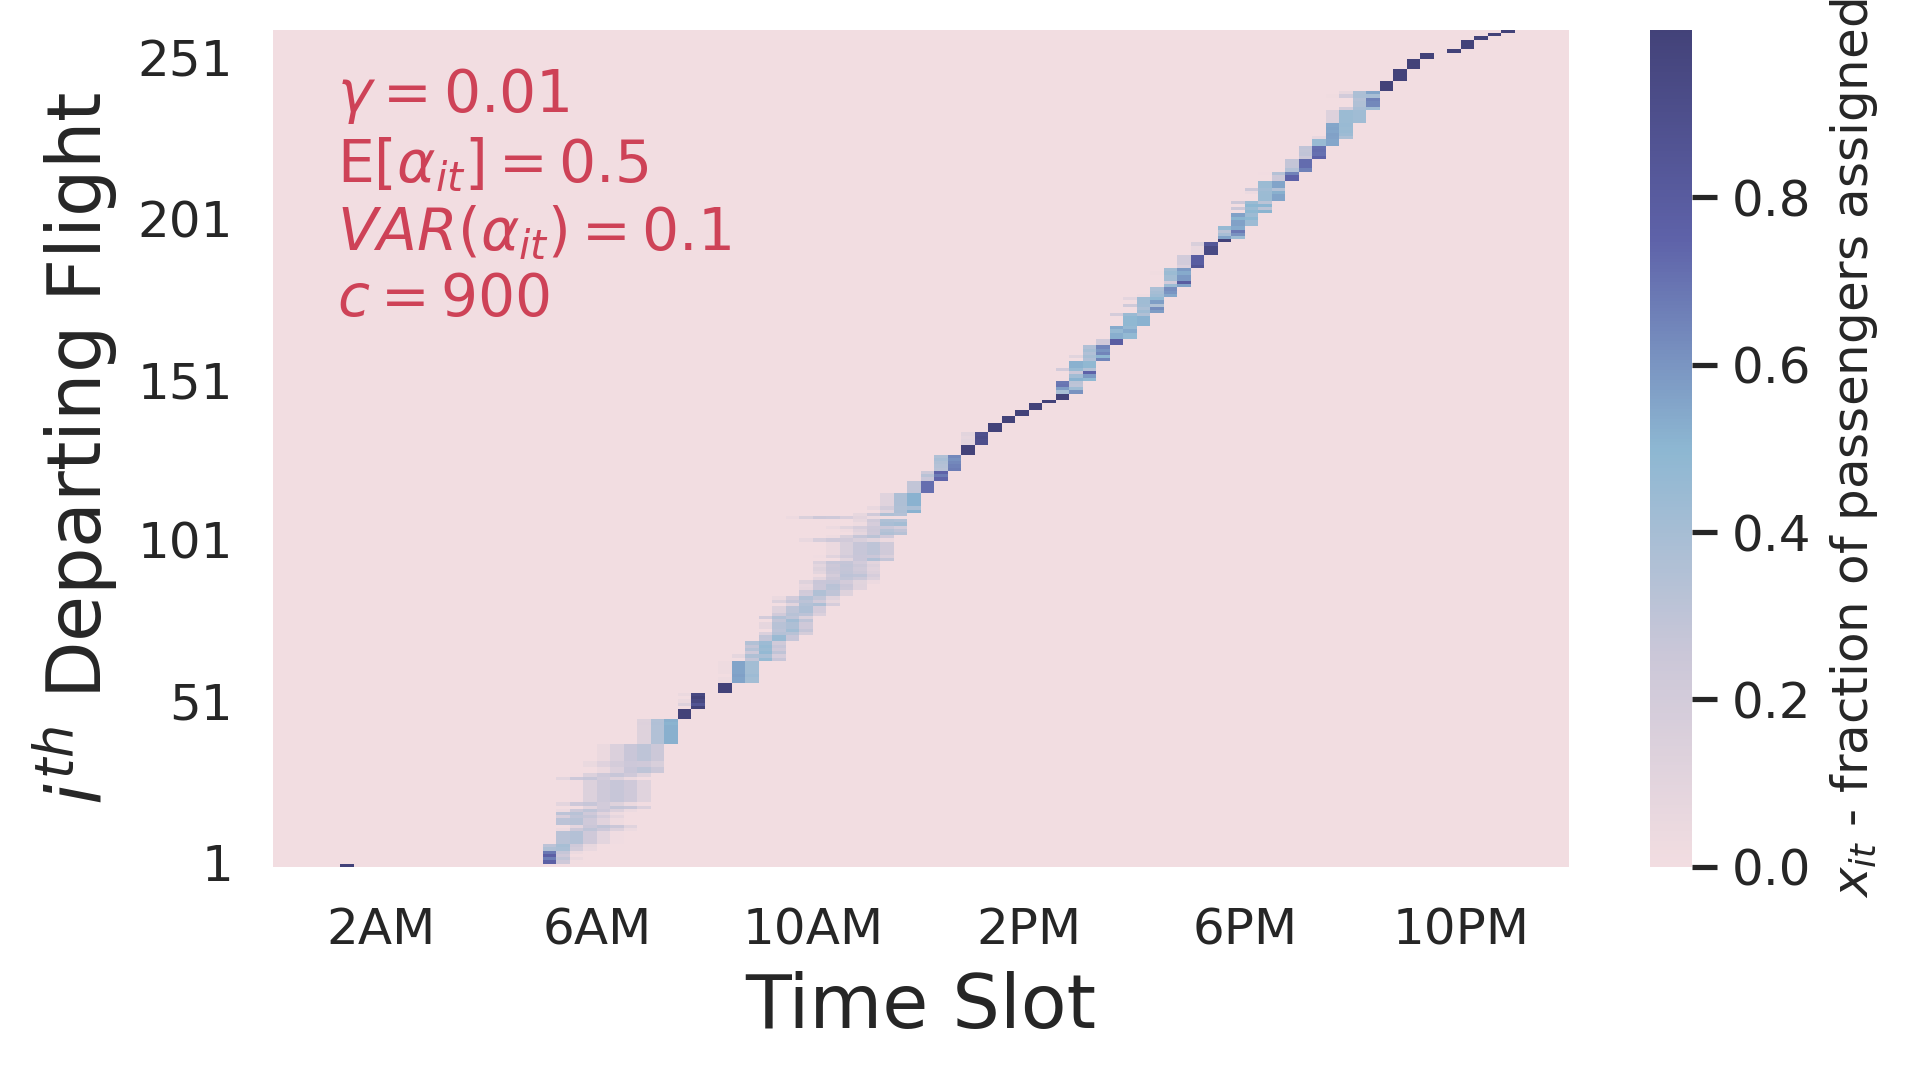

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(6.75,4), dpi=300)
sns.heatmap(solution, cmap=cmap, ax=ax)
ax.set(xlabel='Time Slot', ylabel=r'$i^{th}$ Departing Flight', 
       xticks = [i*16-8 for i in range(1,7)],
       xticklabels=['2AM', '6AM', '10AM', '2PM', '6PM', '10PM'],
       yticks = [i*50 for i in range(6)],
       yticklabels=[i for i in range(1, 301, 50)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r"$x_{it}$ - fraction of passengers assigned", fontsize=12) 
ax.text(
    0.05, 0.80, 
    r'$\gamma = 0.01$' + '\n' + 
    r'$\mathrm{E}[\alpha_{it}]=0.5$' + '\n' +
    r'$VAR(\alpha_{it})=0.1$' + '\n' + 
    r'$c=900$', 
    ha='left', va='center', 
    transform=ax.transAxes, 
    fontsize=14, 
    color='#ce4257'
)

plt.tight_layout()
ax.invert_yaxis()

In [136]:
inst = ROSecurity(df, n_slots=96, cost=c)
solution = inst.run(capacity=900, gamma=0.2, alpha=0.6, sigma=0.1, n_neighbor=1)

100%|██████████| 260/260 [00:00<00:00, 35874.70it/s]


Set parameter NonConvex to value 2


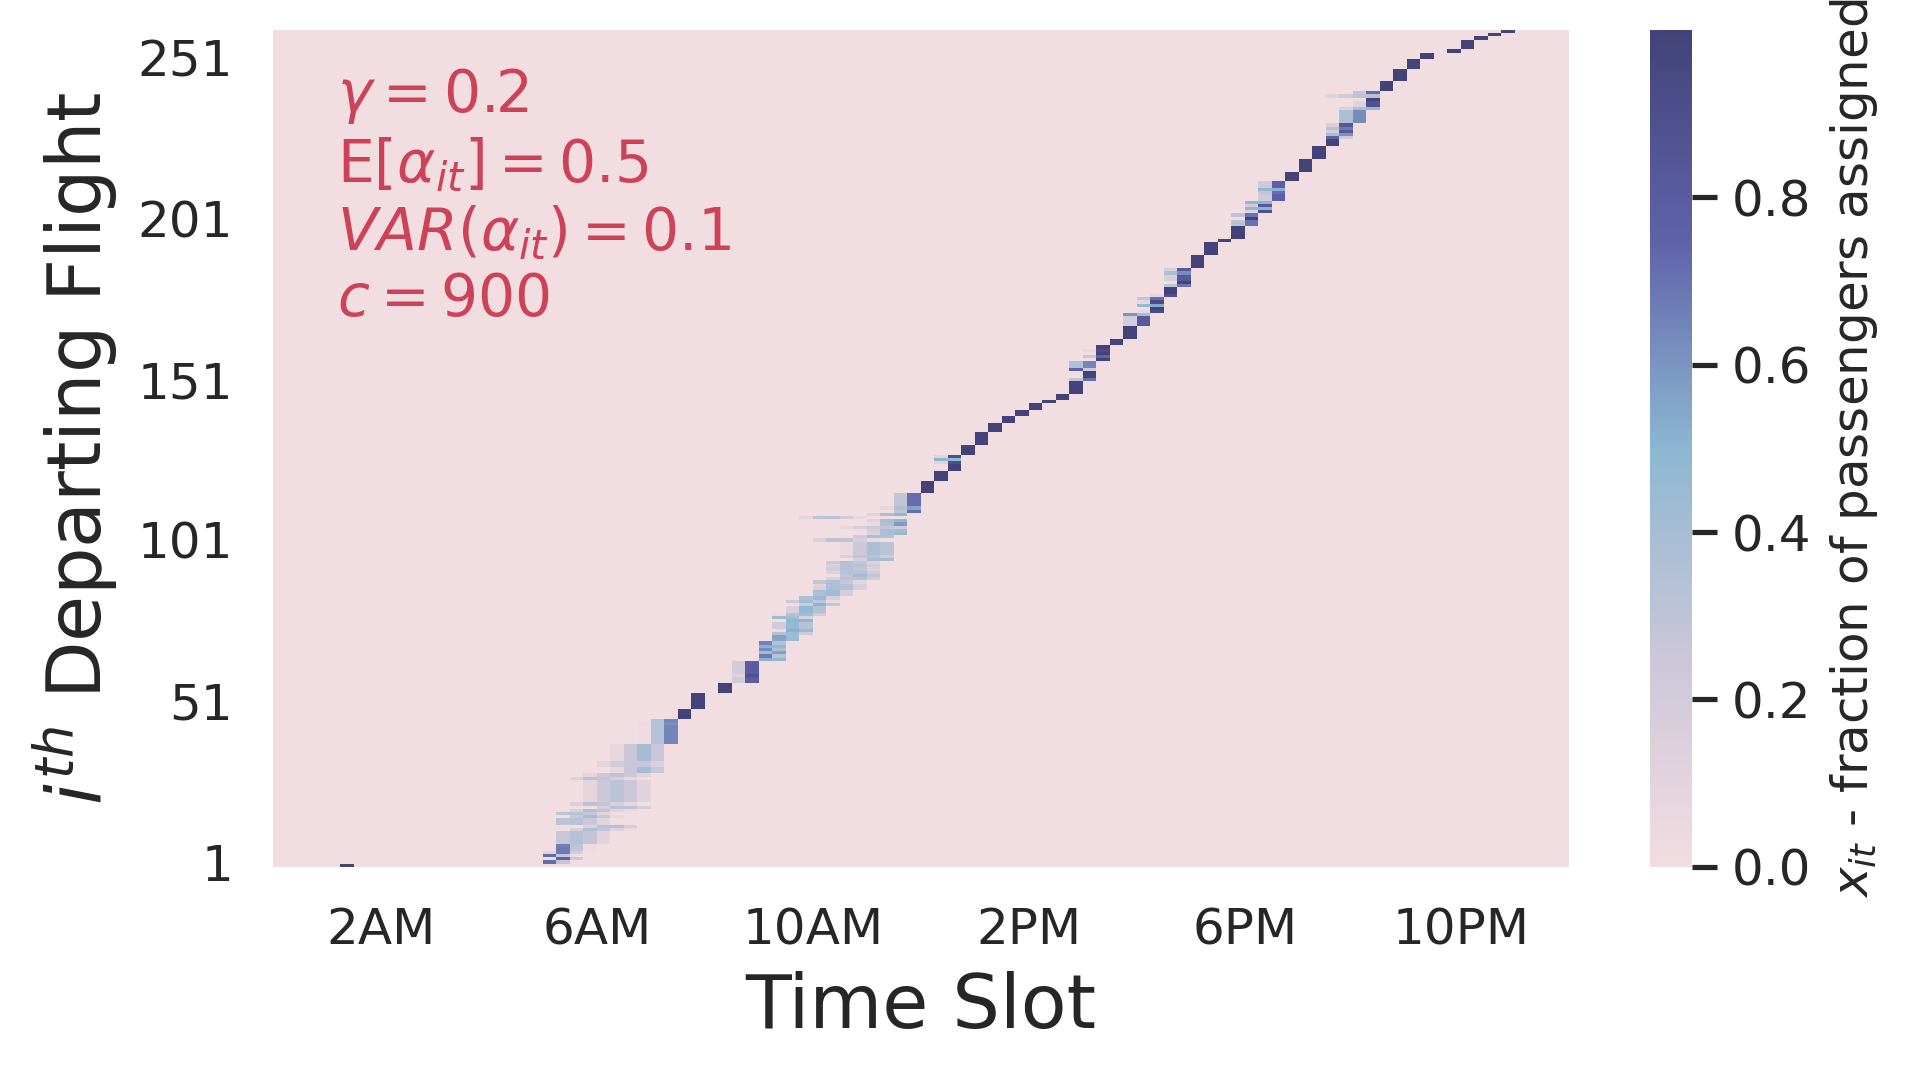

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(6.75,4), dpi=300)
sns.heatmap(solution, cmap=cmap, ax=ax)
ax.set(xlabel='Time Slot', ylabel=r'$i^{th}$ Departing Flight', 
       xticks = [i*16-8 for i in range(1,7)],
       xticklabels=['2AM', '6AM', '10AM', '2PM', '6PM', '10PM'],
       yticks = [i*50 for i in range(6)],
       yticklabels=[i for i in range(1, 301, 50)])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel(r"$x_{it}$ - fraction of passengers assigned", fontsize=12) 
ax.text(
    0.05, 0.80, 
    r'$\gamma = 0.2$' + '\n' + 
    r'$\mathrm{E}[\alpha_{it}]=0.5$' + '\n' +
    r'$VAR(\alpha_{it})=0.1$' + '\n' + 
    r'$c=900$', 
    ha='left', va='center', 
    transform=ax.transAxes, 
    fontsize=14, 
    color='#ce4257'
)

plt.tight_layout()
ax.invert_yaxis()

In [9]:
m = Model('Assignment')
x = m.addVars(c.shape[0], c.shape[1], vtype=GRB.BINARY, name='x')
for i in tqdm(range(c.shape[0])):
    m.addConstr(quicksum(x[i,j] for j in range(c.shape[1])) == 1)
for j in tqdm(range(c.shape[1])):
    m.addConstr(quicksum(x[i,j] for i in range(c.shape[0])) <= cap)
for idx, desired_arrival in enumerate(da):
    m.addConstr(quicksum(x[idx, j] for j in range(int(desired_arrival)+4, int(c.shape[1]))) == 0)

m.setObjective(quicksum(x[i,j]*c[i,j] for i in range(c.shape[0]) for j in range(c.shape[1])), GRB.MINIMIZE)
m.update()
m.setParam('OutputFlag', 0)
m.optimize()
deterministic = np.zeros((pax, c.shape[1]))
for i in range(pax):
    for j in range(c.shape[1]):
        deterministic[i, j] = m.getVarByName(f'x[{i},{j}]').x



100%|██████████| 96/96 [00:00<00:00, 3442.72it/s]


In [10]:
r1 = np.cumsum(solution.sum(axis=0))
r0 = np.cumsum(aft)

In [11]:
dm = np.cumsum(deterministic.sum(axis=0))

In [12]:
r2 = np.cumsum(solution.sum(axis=0))

In [22]:
((r2-dm)*0.25).sum()

57.0

[[<matplotlib.axis.XTick at 0x3159bdb10>,
 [Text(0, 0, '0:00'),
  Text(16, 0, '4:00'),
  Text(32, 0, '8:00'),
  Text(48, 0, '12:00'),
  Text(64, 0, '16:00'),
  Text(80, 0, '20:00'),
  Text(96, 0, '0:00')]]

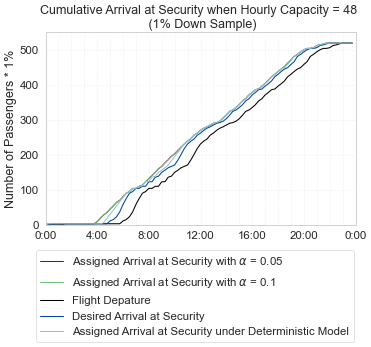

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=50)

ax.plot(r1, label=r'Assigned Arrival at Security with $\alpha$ = 0.05', color = color_platte[0])
ax.plot(r2, label=r'Assigned Arrival at Security with $\alpha$ = 0.1',color = color_platte[3])
ax.plot(aft, label='Flight Depature', color = 'black')
ax.plot(aft[4:], label='Desired Arrival at Security', color = color_platte[1])
ax.plot(dm, label='Assigned Arrival at Security under Deterministic Model',color = color_platte[2])
ax.set(title='Cumulative Arrival at Security when Hourly Capacity = 48 \n (1% Down Sample)' )
ax.legend(title='', bbox_to_anchor=(-0.05, -0.1), loc='upper left')

minorLocator = MultipleLocator(4)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(True, alpha=0.25, linestyle='--', which='both')
ax.set(xlabel='', ylabel='Number of Passengers * 1%', xlim=(0, 96), ylim=(0, 550));
ax.set(xticks=[i*16 for i in range(6)]+[96], xticklabels=[f"{i*4}:00" for i in range(6)]+[f"{0}:00"])

In [ ]:
full = pd.DataFrame({'slots':np.arange(24*4), 'capacity': cap})
full = pd.merge(full, df, on='slots', how='left')
full = full.fillna(0)
full = full.groupby('slots').agg({'capacity':'first', 'Aircraft Capacity':'sum'}).reset_index()
dt = []
vt = full['Aircraft Capacity'].cumsum()
total_departures = 0
arrival_queue = 0
for row in full.iterrows():
    arrival_queue += row[1]['Aircraft Capacity']
    departed = min(cap, arrival_queue)
    arrival_queue -= departed
    total_departures += departed
    dt.append(total_departures)
dt = np.array(dt)
expanded = []
for row in full.iterrows():
    expanded += [row[1]['slots'] for i in range(int(row[1]['Aircraft Capacity']))]

In [ ]:
def process(full, nJ=96):
    da = []
    aft = []
    nI = full['Aircraft Capacity'].sum().astype(int)
    c = np.zeros([nI, nJ])
    beta = 2
    for i in range(nI):
        lead_time = 4
        for j in range(nJ):
            desired_arrival = expanded[i] 
            actual_flight_time = expanded[i]+lead_time
            
            if j < desired_arrival:
                cost = abs(j - desired_arrival)*beta
            else:
                cost = 200
            c[i, j] = cost
        aft.append(actual_flight_time)
        da.append(desired_arrival)

    return c, np.array(aft), np.array(da)

c, aft, da = process(full)
aft = calc_cum_arrive(aft)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=200)
ax[0].plot(vt, label='$v(t)$', color=color_palette[1])
ax[0].plot(dt, label='$d(t)$', color=color_palette[3])
ax[0].plot(aft, label='$q(t)$', color=color_palette[0])
ax[0].set(xticks=np.arange(0, 24*4+1, 4*4), xticklabels=np.arange(0, 25, 4),
       xlabel='Time (hour)', ylabel='N')
ax[0].legend(loc='upper left');


ax[1].plot(reassigned_arrival, color=color_palette[1], label='$\hat{v}(t)$', linestyle='--')
ax[1].plot(reassigned_depature, color=color_palette[3], label='$\hat{d}(t)$', linestyle=':')
ax[1].plot(aft, color=color_palette[0], label='$q(t)$')

ax[1].set(xticks=np.arange(0, 24*4+1, 4*4), xticklabels=np.arange(0, 25, 4),
       xlabel='Time (hour)', ylabel='', yticklabels=[])
ax[1].legend(loc='upper left')
plt.subplots_adjust(wspace=0.05)
plt.tight_layout();